In [1]:
import pandas as pd
import numpy as np
from stop_words import get_stop_words
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.textpath import TextPath
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn import mixture
from collections import Counter
from sklearn.cluster import DBSCAN

In [2]:
#vereinfachte Methode:
def linkage_matrix(n_samples, children, distances):
    """
    create a linkage matrix for the dendogram method in scipy
    n_samples: int, number of samples
    children: list of lists, clustered data points (should be 2)
    distances: list of distances between nodes
    """
    # Create linkage matrix
    

    # create the counts of samples under each node
    counts = np.zeros(children.shape[0])
    for i, merge in enumerate(children):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack([children, distances, counts]).astype(float)

# Gibt eine Worthäufigkeitsliste zurück, nur den Namen des Genre in Form eines Strings als Argument.
def wordlister(genre):
    stop_words = get_stop_words('de')
    stop_words.append('ch00ffff')
    # Alle Texte eines Genres konkatenieren
    film_genre = ""
    for film in df.iterrows():
        if film[1].genre == genre:
            film_genre = film_genre + film[1].text
    # Tokenisieren
    genre_tokens = re.findall("\w+", film_genre.lower())
    # Stopwordliste 
    tokens_without_stopwords =[]
    for word in genre_tokens:
        if word not in stop_words:
            tokens_without_stopwords.append(word)
    #Rückgabe mit gezählten Tokens
    return Counter(tokens_without_stopwords)



# Plottet die Wörterliste aus der oberen Funktion, mit .most_common() kann die Zahl begrenzt werden.
def wordlistplot(wordlist):
    plt.figure(figsize=(15,8))
    for word in wordlist:
        x= word[0]
        y = word[1]
        plt.bar(x, y)
    plt.show()
    
#Filter der nicht Stop-Wörter herausfiltert.    
def filter_non_stopwords(s, stopwords=get_stop_words('de')):
    stopwords = set([t.lower() for t in stopwords])
    token = re.findall(r'\w+', s.lower())
    return " ".join([t for t in token if t in stopwords])

In [3]:
df = pd.read_csv('../../dataset/movies_complete.csv')
df.dropna(subset=['genre'], inplace=True)
df.dropna(subset=['Language'], inplace=True)
df['text_length'] = df.text.apply(lambda x: len(x.split()))
df = df[df['text_length'] >= 3000]
df.shape

(3479, 56)

In [4]:
df['only_stopwords'] = df.text.apply(filter_non_stopwords)

In [5]:
df.head()

,Unnamed: 0,filename,text,IMDB_ID,genre,year,production_region,corpus,duration,directors,...,Metascore,imdbRating,imdbVotes,Type,DVD,BoxOffice,Production,Website,Response,only_stopwords
0,0,6416324.xml,Der Roman von Alexandre Dumas dem Älteren hatt...,tt1104767,"Adventure,Drama,History",1943.0,French,untokenisiert,90.0,"nm0894509,nm0148602",...,NaN,7.1,76,movie,NaN,NaN,NaN,NaN,True,der von dem hatte einen er sich wieder der man...
1,1,4732286.xml,Hände hoch oder ich schieße ( 1966 ) dTV - MDR...,tt1631717,Comedy,1966.0,German,untokenisiert,75.0,nm0440757,...,NaN,6.0,19,movie,NaN,NaN,NaN,NaN,True,oder ich das ist ein wie es einige seine und s...
2,2,6122081.xml,"Hallo , Manuela ? Störe ich ? Kann ich zu dir ...",tt1271979,Drama,1967.0,French,untokenisiert,78.0,nm0816215,...,NaN,6.6,25,movie,NaN,NaN,NaN,NaN,True,ich kann ich zu dir hab sie ich kann nicht son...
3,3,5594522.xml,Dein Vater war ein ausgezeichneter Kämpfer . A...,tt3141954,"Action,Adventure",1978.0,Cantonese,untokenisiert,82.0,nm1172472,...,NaN,5.8,23,movie,NaN,NaN,NaN,NaN,True,dein war ein aber er hat dass das war ein auf ...
4,4,5618549.xml,"Na los , iss jetzt schnell auf . Junge , ist d...",tt1065116,Action,1979.0,Japanese,untokenisiert,96.0,nm0814232,...,NaN,5.6,32,movie,NaN,NaN,NaN,NaN,True,jetzt auf ist der wenn du bist deine auf zu wi...


In [6]:
genre_combination_frequs = Counter(df.genre)
genre_combination_frequs.most_common()

[('Drama', 370),
 ('Comedy', 195),
 ('Comedy,Drama', 139),
 ('Drama,Romance', 132),
 ('Comedy,Drama,Romance', 116),
 ('Comedy,Romance', 85),
 ('Horror', 77),
 ('Drama,Thriller', 74),
 ('Horror,Thriller', 69),
 ('Action,Crime,Drama', 67),
 ('Adventure,Animation,Comedy', 65),
 ('Documentary', 64),
 ('Crime,Drama,Thriller', 62),
 ('Thriller', 53),
 ('Action,Crime,Thriller', 49),
 ('Action,Comedy,Crime', 41),
 ('Action,Adventure,Sci-Fi', 41),
 ('Action', 36),
 ('Action,Adventure,Drama', 36),
 ('Crime,Drama', 35),
 ('Biography,Drama,History', 30),
 ('Biography,Drama', 30),
 ('Crime,Drama,Mystery', 30),
 ('Action,Thriller', 28),
 ('Horror,Mystery,Thriller', 28),
 ('Action,Adventure,Comedy', 28),
 ('Comedy,Horror', 27),
 ('Comedy,Crime,Drama', 26),
 ('Action,Adventure,Fantasy', 25),
 ('Action,Adventure,Animation', 22),
 ('Crime,Thriller', 22),
 ('Family', 22),
 ('Action,Horror,Sci-Fi', 20),
 ('Biography,Drama,Romance', 20),
 ('Action,Comedy', 19),
 ('Action,Drama', 19),
 ('Action,Drama,Histor

## Vorbereitung der Label und Slice auf die Genre

In [7]:
#Documentary und Action, Crime, Drama
labelcolor = []
for index, row in df.iterrows():
    if (row['genre'] == 'Documentary') == True:            #Documentary
        labelcolor.append('red')    #red
    elif (row['genre'] == 'Action,Crime,Drama') == True:              #Action,Crime,Drama
        labelcolor.append('blue')   #blue
    else: 
        labelcolor.append('white')
df['labelcolor']=labelcolor    
#df = df.loc[dfs_movie['originalTitle'] != 'Geisha vs ninja'] 
#df = df.loc[dfs_movie['originalTitle'] != 'Dao jiàn xiào'] 
df_2genre = df[df.labelcolor != 'white']
#pd.value_counts(df_2genre.labelcolor).plot.bar() 
#pd.value_counts(df_2genre.labelcolor)  

## TFIDF - Agglomerative Clustering

In [8]:
#tf-idf
stop_words = get_stop_words('de')
stop_words.append('ch00ffff')
tfidf = TfidfVectorizer(max_features=100, stop_words=stop_words) #, stop_words=get_stop_words('de'))
tokens = tfidf.fit_transform(df_2genre.text)
hier_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(tokens.todense())

## Dendrogram

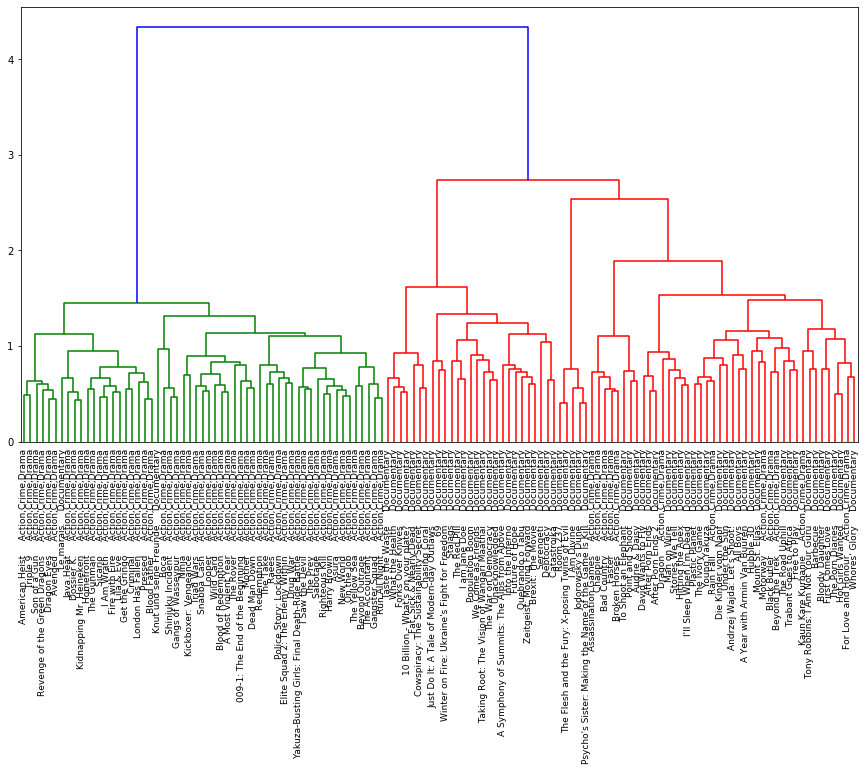

In [9]:
lmatrix = linkage_matrix(tokens.shape[0], hier_model.children_, hier_model.distances_)
plt.figure(figsize=(15,8))
dendrogram(lmatrix, labels=(df_2genre['Title'].values + "     " + df_2genre['genre'].values), leaf_font_size=9);

## Wordlist

In [10]:
count_docu = wordlister('Documentary')
#print(wordlistplot(count_docu.most_common(1000)))
count_docu.most_common(40)

[('ja', 1383),
 ('mehr', 1268),
 ('immer', 1067),
 ('gibt', 969),
 ('wurde', 953),
 ('leben', 872),
 ('gut', 871),
 ('menschen', 840),
 ('mal', 773),
 ('leute', 742),
 ('sagte', 717),
 ('geht', 711),
 ('viele', 709),
 ('schon', 650),
 ('sehen', 649),
 ('einfach', 634),
 ('sagen', 618),
 ('weiß', 576),
 ('nein', 568),
 ('wirklich', 550),
 ('welt', 550),
 ('tun', 538),
 ('zwei', 524),
 ('nie', 516),
 ('zeit', 515),
 ('tag', 507),
 ('heute', 484),
 ('¼', 482),
 ('film', 480),
 ('warum', 478),
 ('müssen', 469),
 ('macht', 466),
 ('ganz', 443),
 ('geld', 427),
 ('gab', 421),
 ('jahre', 421),
 ('gehen', 417),
 ('hast', 406),
 ('wissen', 403),
 ('glaube', 394)]

In [11]:
count_action_crime_drama = wordlister('Action,Crime,Drama')
#print(wordlistplot(count_action_crime_drama.most_common(1000))) 
count_action_crime_drama.most_common(40)

[('ja', 3096),
 ('hast', 1536),
 ('nein', 1490),
 ('mal', 1380),
 ('schon', 1334),
 ('los', 1326),
 ('gut', 1317),
 ('s', 1177),
 ('hey', 927),
 ('geht', 895),
 ('mann', 879),
 ('wer', 848),
 ('komm', 836),
 ('weiß', 827),
 ('okay', 827),
 ('bitte', 766),
 ('mehr', 726),
 ('scheiße', 649),
 ('gehen', 638),
 ('immer', 635),
 ('tun', 613),
 ('warum', 599),
 ('willst', 589),
 ('geld', 576),
 ('na', 565),
 ('gibt', 558),
 ('danke', 521),
 ('leben', 516),
 ('sehen', 511),
 ('wissen', 506),
 ('sagen', 483),
 ('müssen', 479),
 ('raus', 478),
 ('kommen', 465),
 ('kommt', 465),
 ('klar', 463),
 ('ganz', 456),
 ('zwei', 455),
 ('lass', 448),
 ('lassen', 445)]

In [12]:
for title in df_2genre.Title:
    print(title)

Kaun Kare Kurbanie
Le marais
Young Yakuza
The War on Democracy
For Love and Honour
Righteous Kill
Man on Wire
Triad Wars
Knut und seine Freunde
Taking Root: The Vision of Wangari Maathai
The Porn Diaries
69
Stalags
Shinjuku Incident
Ninja
Rain Fall
Mother
Dossier K.
Harry Brown
Plastic Planet
Andrzej Wajda: Let's Shoot!
Mount St. Elias
To Shoot an Elephant
All Boys
Fat, Sick & Nearly Dead
The Yellow Sea
Snabba Cash
Faster
Hubble 3D
Elite Squad 2: The Enemy Within
I Saw the Devil
David Wants to Fly
Yakuza-Busting Girls: Final Death-Ride Battle
Future of Hope
Boca
Taste the Waste
Whores' Glory
Assassination Games
Forks Over Knives
Pressed
Dragon
The Prey
Zeitgeist: Moving Forward
Serengeti
Trabant Goes to Africa
Debtocracy
The Road Uphill
Just Do It: A Tale of Modern-day Outlaws
Quebrando o Tabu
Die Kinder vom Napf
Looper
After Porn Ends
Get the Gringo
Beyond Outrage
Dragon Eyes
Motorway
Fire with Fire
Gangs of Wasseypur
Room 237
Drug War
The Flesh and the Fury: X-posing Twins of Evil
St

In [13]:
def wordlistersingle(title):
    singletitle = df.loc[(df['Title'] == title)]
    idx = df.index[df['Title'] == title]
    
    single_tokens = re.findall("\w+", singletitle.at[idx[0],'text'].lower())
    tokens_without_stopwords =[]
    for word in single_tokens:
        if word not in stop_words:
            tokens_without_stopwords.append(word)
    return Counter(tokens_without_stopwords), singletitle.at[idx[0],'text'], singletitle


count_singletitle, text_singletitle, df_singletitle = wordlistersingle('Dragon')
#Ghost in the Shell
#Le marais
count_singletitle.most_common(40)

[('jinxi', 28),
 ('tang', 25),
 ('vater', 24),
 ('long', 22),
 ('liu', 21),
 ('kommen', 14),
 ('hast', 12),
 ('xu', 12),
 ('yan', 11),
 ('gehen', 11),
 ('sagte', 11),
 ('sohn', 11),
 ('schon', 10),
 ('immer', 10),
 ('dorf', 10),
 ('wurde', 10),
 ('nie', 10),
 ('mehr', 10),
 ('zehn', 10),
 ('dongsheng', 9),
 ('mann', 9),
 ('dämonen', 9),
 ('ja', 8),
 ('jingzhou', 8),
 ('tot', 8),
 ('jahre', 8),
 ('wäre', 8),
 ('baijiu', 8),
 ('xiaotian', 7),
 ('gut', 7),
 ('warum', 7),
 ('sogar', 7),
 ('fall', 7),
 ('schlachter', 7),
 ('mensch', 7),
 ('menschen', 7),
 ('leben', 7),
 ('72', 7),
 ('bruder', 7),
 ('phase', 7)]

In [14]:
df_singletitle

,Unnamed: 0,filename,text,IMDB_ID,genre,year,production_region,corpus,duration,directors,...,imdbRating,imdbVotes,Type,DVD,BoxOffice,Production,Website,Response,only_stopwords,labelcolor
1239,1239,5023525.xml,"Vater . - Was ist denn , Xiaotian ? Mein Zahn ...",tt1718199,"Action,Crime,Drama",2011.0,Mandarin,untokenisiert,115.0,nm0151066,...,7.1,"13,354",movie,16 Apr 2013,"$11,137",Radius/The Weinstein Co.,NaN,True,was ist denn mein was ist mit dem ich nach wel...,blue


In [15]:
text_singletitle

'Vater . - Was ist denn , Xiaotian ? Mein Zahn tut weh . - Komm mal her . Was ist mit dem Zahn ? Ich sehe mal nach . Welcher Zahn ist es ? Mach den Mund weit auf . Noch ein bisschen . Ist es der hier ? Oder der ? Oder der hier ? Zeig mal . Zhigens Frau kam gestern zur Papiermühle . Sie schimpfte alle , die nicht zur Feier ihres Neugeborenen gekommen waren . Ich war beschäftigt und verschwand lieber . Wirklich wahr ? Bei ihrem Bauch meint man , das Kind kommt erst noch . Findest du ? Wann kriegst du noch ein Kind ? Das fragt man nicht . - Wer so viel fragt , wird eingetauscht . Das werde ich nicht . - Das wirst du wohl . Nein . - Doch . Nein . Jinxi . - Ja ? Hast du schon gegessen ? Es gibt Fleischeintopf . Danke , ich esse kein Fleisch . - Stimmt ja . Du isst kein Fleisch . Das vergesse ich immer . Seit es die Papiermühle gibt , geht es dem Dorf gut . Viele Fremde kaufen hier ihr Papier . Wir sind wegen des Geldes hier . Ihr wollt sicher Papier kaufen . Wir sind wegen des Geldes hier .

## Als Action, Crime, Drama eingeordnet:
##### Le Marais: 
Dokumentation zeigt das alltägliche leben in Le Marais, die Dokumentation besteht hauptsächlich aus Dialogen mit den Leuten dort -> alltagssprache; häufigsten Wörter stimmen mehr mit Action, Crime Drama überein
##### Die Kinder vom Napf:
Alltagssprache, einfache Wörter, Dialoge mit Kindern -> enthält nicht die typische sachliche Sprache der meisten Dokumentationen
##### Plastic Planet 
Trotz fachlichem Jargon, viele Interviews und Dialoge in alltagssprache, Präsens, Perfekt und Indikativ, wenig Konjunktiv und passiv oder Präteritum. Wenig Erzähleranteile, wirkt mehr wie eine Reportage in der der verantwortliche Journalist subjektiv und emotional das Geschehen beschreibt.
##### Young Yakuza 
Viel "Dialog" und nachgespielte Szenen, raue alltagssprache, Kraftausdrücke, etc.  -> Die Sprache passt gut in das Action, Crime, Drama Milieu

## Als Documentary eingeordnet:
##### Kajinek 
Textdaten fehlerhaft, enthalten nicht die Untertitel sondern eine Plotbeschreibung
##### Ghost in a Shell:
Nur die Dialoge sind untertitelt, nicht aber die "Erzählstimme" -> Extrem kurz, sachliche, fast schon militärische Sprache
##### Beyond the Track
Viele spezifische "Fachbegriffe" sci-fi, neben Alltagsdialogen viel "sachliche" Sprache und Präteritum, vgl. Bericht
##### Motorway 
viele asiatische Namen für Automobil und Motorrad spezifische Begriffe. Keine Kraftausdrücke oder raue Sprache
##### Kaun Kare Kurbanie
auffallend häufig passive oder konjunktive Sprache und Präteritum. Ebenso wenig Perfekt, wie es in der heutigen Alltagssprache gängig ist, bsp. " Wir wünschen , dass es einen tapferen Mann gab , der gut an Herzen wäre "
##### Colombiana
Untertiteltext enthält nur eine Szene aus dem Film -> sehr kurz


## Zusammenfassung
Die Wortformen, die die alltagssprache von der sachlichen Unterscheiden scheinen ein ausschlaggebender Faktor zu sein für die "falsch" eingeordneten Instanzen. Aber auch typische Begriffe der Alltagssprache haben einen großen Anteil, z.B. "okay", "danke", aber auch Kurzformen, wie "geht's" treten überwiegend im Action, Crime, Drama Cluster auf

Ich habe das Documentary - Action, Crime, Drama Cluster weitgehend untersucht, ein paar Sachen möchte ich noch machen, die meisten "falsch" eingeordneten Instanzen lassen sich nachvollziehen, leider sind auch welche dabei, bei denen die Texte fehlerhaft sind. Einmal haben wir eine Plotbeschreibung und einmal nur eine einzige Szene aus dem Film. In einem dritten Fall enthält der Text nur die Dialoge aber nicht die den großteil ausmachende Erzähstimme.

# Language Cluster - deutsch japanisch

In [16]:
colors = []
for x in df.Language:
    if x == 'German':
        colors.append('red')
    elif x == 'Japanese':
        colors.append('blue')
    else: 
        colors.append('white')
df['colors']=colors      
df_2languages = df[df.colors != 'white']

## Hierarchisches Cluster

In [62]:
df_sample = df_2languages.sample(frac=0.2)
df_sample.shape

(58, 59)

In [68]:
#tf-idf
stop_words = get_stop_words('de')
stop_words.append('ch00ffff')
tfidf = TfidfVectorizer(max_features=100, stop_words=stop_words) #, stop_words=get_stop_words('de')) , stop_words=stop_words
tokens = tfidf.fit_transform(df_sample.text)  #.only_stopwords
hier_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(tokens.todense())

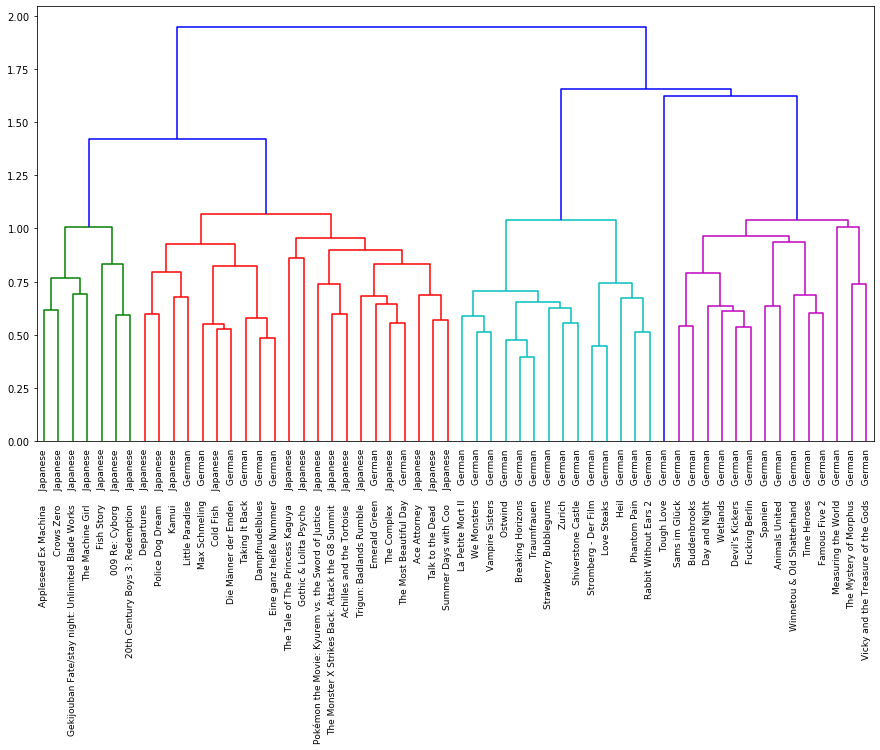

In [69]:
lmatrix = linkage_matrix(tokens.shape[0], hier_model.children_, hier_model.distances_)
plt.figure(figsize=(15,8))
dendrogram(lmatrix, labels=(df_sample['Title'].values + "     " + df_sample['Language'].values), leaf_font_size=9);

In [95]:
def wordlistersingle(title):
    singletitle = df_sample.loc[(df_sample['Title'] == title)]
    idx = df_sample.index[df_sample['Title'] == title]
    
    single_tokens = re.findall("\w+", singletitle.at[idx[0],'text'].lower())
    tokens_without_stopwords =[]
    for word in single_tokens:
        if word not in stop_words:
            tokens_without_stopwords.append(word)
    single_tokens2 = re.findall("\w+", singletitle.at[idx[0],'only_stopwords'].lower())
    tokens_with_stopwords =[]
    for word in single_tokens2:
        tokens_with_stopwords.append(word)
    return Counter(tokens_without_stopwords),Counter(tokens_with_stopwords),  singletitle.at[idx[0],'text'], singletitle


count_singletitle, count_stopwords, text_singletitle, df_singletitle = wordlistersingle('Spanien')
#Ghost in the Shell
#Le marais
print(sum(count_singletitle.values()), sum(count_stopwords.values()))

1214 1176


# Zusammenfassen der Genre Texte

In [20]:
data=[]
texts =[]
genres=[]
for genre in df.genre.unique():
    text = ""
    for instance in df.iterrows():
        if instance[1].genre == genre:
            text = text + instance[1].text
    data.append({
                'genre': genre,
                'text': text,                            
            })
df_genre = pd.DataFrame.from_dict(data)
print(df_genre.shape)
df_genre.head()

(352, 2)


,genre,text
0,"Adventure,Drama,History",Der Roman von Alexandre Dumas dem Älteren hatt...
1,Comedy,Hände hoch oder ich schieße ( 1966 ) dTV - MDR...
2,Drama,"Hallo , Manuela ? Störe ich ? Kann ich zu dir ..."
3,"Action,Adventure",Dein Vater war ein ausgezeichneter Kämpfer . A...
4,Action,"Na los , iss jetzt schnell auf . Junge , ist d..."


In [21]:
df_genre.dropna(subset=['genre'], inplace=True)

In [22]:
genre_test = "Action"
for x in df_genre.iterrows():
    if x[1].genre == genre_test:
        print(len(x[1].text))

text = ""
for instance in df.iterrows():
    if instance[1].genre == genre_test:
        text = text + instance[1].text
print(len(text))

1117565
1117565


In [23]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=100, stop_words=stop_words)
tokens = tfidf.fit_transform(df_genre.text)

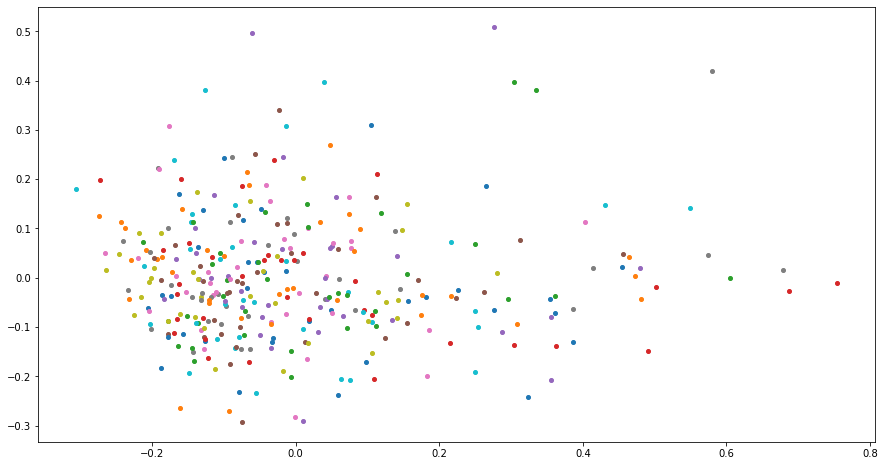

In [24]:
pca = PCA(n_components=2)
pca.fit(tokens.todense())
X_tf = pca.transform(tokens.todense())

#Abspeichern der Zwischenergebnisste im Datafram
df_genre['pcatokens_1'] = X_tf[:,0]
df_genre['pcatokens_2'] = X_tf[:,1]

#Plotten anhand der gespeicherten Zwischenergebnisse 
plt.figure(figsize=(15,8))
for d in df_genre.iterrows():
    x = d[1].pcatokens_1
    y = d[1].pcatokens_2    
    plt.plot(x, y, 'o', markersize=4)
    #plt.plot(x, y, marker=TextPath((-3, -3), f'{d[1].kmeanstokens}'), color='black', markersize=1)

In [25]:
import plotly.graph_objects as go
import plotly.express as px
text_data = [
    f'{row.genre}|'
    for index, row in df_genre.iterrows()
]
fig = go.Figure(data=go.Scatter(x=X_tf[:, 0],
                                y=X_tf[:, 1],
                                mode='markers',
                                text=text_data))
fig.show()

## Hierarchisches Cluster mit zusammengefassten Genres

In [26]:
df_genre_sample = df_genre.sample(frac=0.2)

In [27]:
tfidf = TfidfVectorizer(max_features=10000, stop_words=stop_words)
df_genre_token = tfidf.fit_transform(df_genre_sample.text)

hier_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(df_genre_token.todense())

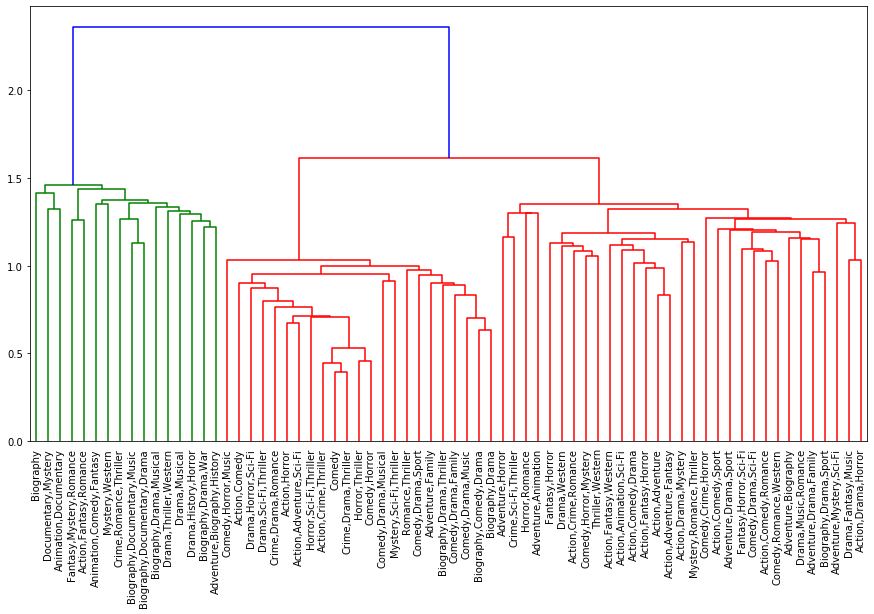

In [28]:
lmatrix = linkage_matrix(df_genre_token.shape[0], hier_model.children_, hier_model.distances_)
plt.figure(figsize=(15,8))
dendrogram(lmatrix, labels=df_genre_sample['genre'].values, leaf_font_size=10); #